---- Overall balances ----
D = 85.3 mol/h
W = 114.7 mol/h

---- Theoretical case (100% efficiency) ----
Theoretical stages (incl reboiler) = 11.86
Theoretical trays (excl reboiler) = 10.86

---- Murphree efficiency case ----
Em = 0.55
Actual trays needed (excl reboiler) = 22.000

---- Overall tray efficiency ----
V/L = 1.400000
EO (overall efficiency) = 1.696959
Actual trays from EO correlation = 6.400


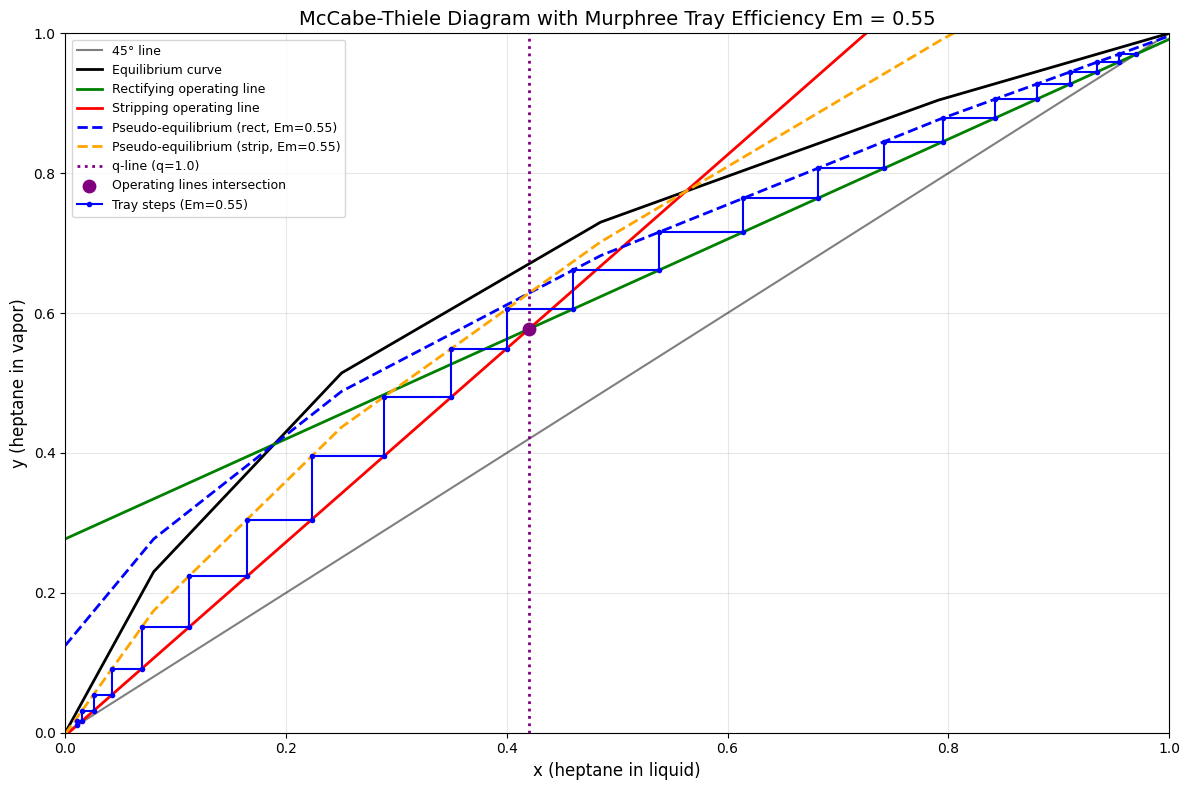


--- Tray step coordinates ---
Tray 1: (0.9700, 0.9700) → (0.9544, 0.9700)
Tray 2: (0.9544, 0.9588) → (0.9349, 0.9588)
Tray 3: (0.9349, 0.9449) → (0.9106, 0.9449)
Tray 4: (0.9106, 0.9275) → (0.8802, 0.9275)
Tray 5: (0.8802, 0.9059) → (0.8425, 0.9059)
Tray 6: (0.8425, 0.8789) → (0.7953, 0.8789)
Tray 7: (0.7953, 0.8452) → (0.7418, 0.8452)
Tray 8: (0.7418, 0.8070) → (0.6816, 0.8070)
Tray 9: (0.6816, 0.7640) → (0.6140, 0.7640)
Tray 10: (0.6140, 0.7157) → (0.5379, 0.7157)
Tray 11: (0.5379, 0.6613) → (0.4599, 0.6613)
Tray 12: (0.4599, 0.6056) → (0.3999, 0.6056)
Tray 13: (0.3999, 0.5493) → (0.3499, 0.5493)
Tray 14: (0.3499, 0.4801) → (0.2886, 0.4801)
Tray 15: (0.2886, 0.3953) → (0.2233, 0.3953)
Tray 16: (0.2233, 0.3048) → (0.1646, 0.3048)
Tray 17: (0.1646, 0.2236) → (0.1119, 0.2236)
Tray 18: (0.1119, 0.1506) → (0.0692, 0.1506)
Tray 19: (0.0692, 0.0916) → (0.0424, 0.0916)
Tray 20: (0.0424, 0.0545) → (0.0256, 0.0545)
Tray 21: (0.0256, 0.0312) → (0.0150, 0.0312)
Tray 22: (0.0150, 0.0165) → (0.01

In [19]:
# notebooks/26.5_1.py
# McCabe-Thiele diagram with Murphree tray efficiency (Em = 0.55)
# Construction method:
# 1. Start at condenser (xD, xD)
# 2. For each tray: 
#    - Horizontal line to pseudo-equilibrium line (accounts for Murphree efficiency)
#    - Vertical line to operating line
# 3. Pseudo-lines switch automatically at feed composition:
#    - Above feed: use rectifying pseudo-line y_p_rect(x)
#    - Below feed: use stripping pseudo-line y_p_strip(x)
# 4. Operating lines also switch at feed:
#    - Above feed: original enriching line y_op_rect(x)
#    - Below feed: original stripping line y_op_strip(x)
# 5. Steps continue until reaching xW (reboiler)

import sys
import numpy as np
import matplotlib.pyplot as plt

sys.path.insert(0, "..")

from bank.Distillation.distillation_mccabe_thiele_xy_base import (
    XYEquilibrium,
    McCabeThieleXYSpec,
    solve_mccabe_thiele_xy,
)

from bank.Distillation.distillation_tray_efficiencies_base import (
    TrayEfficiencySpec,
    tray_efficiency_block,
)

# -----------------------------
# Problem data (26.4-2)
# -----------------------------
F  = 200.0    # Feed rate, mol/h
zF = 0.42     # Feed composition
xD = 0.97     # Distillate composition
xW = 0.011    # Bottoms composition
R  = 2.5      # Reflux ratio
q  = 1.0      # Feed condition (bubble point liquid)
Em = 0.55     # Murphree tray efficiency

# Equilibrium data (heptane/ethyl benzene)
x_eq = [0.000, 0.080, 0.250, 0.485, 0.790, 1.000]
y_eq = [0.000, 0.230, 0.514, 0.730, 0.904, 1.000]
eq = XYEquilibrium(x=x_eq, y=y_eq)

# -----------------------------
# Solve theoretical case (Em = 1.0) to get operating lines
# -----------------------------
out_th = solve_mccabe_thiele_xy(
    McCabeThieleXYSpec(eq=eq, F=F, zF=zF, x_D=xD, x_W=xW, R=R, q=q, max_stages=5000)
)

D = out_th["flows"]["D"]
W = out_th["flows"]["W"]

mR = out_th["lines"]["rectifying"]["slope"]
bR = out_th["lines"]["rectifying"]["intercept"]
mS = out_th["lines"]["stripping"]["slope"]
bS = out_th["lines"]["stripping"]["intercept"]
x_int = out_th["intersection"]["x_int"]
y_int = out_th["intersection"]["y_int"]

N_steps_th = out_th["stages"]["N_theoretical"]     # includes reboiler
N_trays_th = N_steps_th - 1.0                      # excludes reboiler

# Operating line functions
def y_op_rect(x):  return mR * x + bR
def y_op_strip(x): return mS * x + bS
def y_eq_func(x):  return eq.y_of_x(float(x))

# Pseudo-equilibrium lines for Murphree efficiency
# y_p(x) = y_op(x) + Em * [y_eq(x) - y_op(x)]
def y_p_rect(x):
    yo = y_op_rect(x)
    return yo + Em * (y_eq_func(x) - yo)

def y_p_strip(x):
    yo = y_op_strip(x)
    return yo + Em * (y_eq_func(x) - yo)

# Select appropriate line based on location relative to feed
def y_pseudo(x):
    """Pseudo-equilibrium line: rectifying above feed, stripping below feed"""
    if x >= zF:
        return y_p_rect(x)
    else:
        return y_p_strip(x)

def y_op(x):
    """Operating line: enriching above feed, stripping below feed"""
    if x >= zF:
        return y_op_rect(x)
    else:
        return y_op_strip(x)

# Root-finding for horizontal steps
def find_x_at_y(y_target, f, x_min, x_max, tol=1e-12):
    """Find x where f(x) = y_target within [x_min, x_max] using bisection"""
    if x_min > x_max:
        x_min, x_max = x_max, x_min
    
    # Generate initial guesses to find bracket
    x_try = np.linspace(x_min, x_max, 20)
    y_try = np.array([f(x) for x in x_try])
    
    # Find interval where function crosses target
    for i in range(len(x_try)-1):
        if (y_try[i] - y_target) * (y_try[i+1] - y_target) <= 0:
            xa, xb = x_try[i], x_try[i+1]
            break
    else:
        # No crossing - return closest point
        idx = np.argmin(np.abs(y_try - y_target))
        return x_try[idx]
    
    # Bisection on bracketed interval
    fa = f(xa) - y_target
    fb = f(xb) - y_target
    
    for _ in range(200):
        xm = 0.5 * (xa + xb)
        fm = f(xm) - y_target
        if abs(fm) <= tol:
            return xm
        if fa * fm <= 0:
            xb, fb = xm, fm
        else:
            xa, fa = xm, fm
    
    return 0.5 * (xa + xb)

def construct_murphree_steps():
    """
    Construct McCabe-Thiele steps with Murphree efficiency.
    
    For each tray:
    1. Start at (x_n, y_n) on operating line
    2. Move horizontally to pseudo-equilibrium line at same y: (x_{n+1}, y_n)
    3. Move vertically to operating line: (x_{n+1}, y_{n+1})
    
    Process continues from xD down to xW.
    """
    points = [(xD, xD)]  # Start at condenser (on diagonal)
    x_current = xD
    y_current = xD
    stage_count = 0
    max_stages = 200
    
    while x_current > xW + 1e-12 and stage_count < max_stages:
        # Find x on pseudo-line at current y
        x_next = find_x_at_y(y_current, y_pseudo, xW, x_current)
        
        # Check if we've reached the reboiler
        if x_next <= xW + 1e-12:
            # Fractional stage to exactly hit xW
            if abs(x_current - x_next) < 1e-14:
                frac = 1.0
            else:
                frac = (x_current - xW) / (x_current - x_next)
                frac = max(0.0, min(1.0, frac))
            
            # Add fractional step
            points.append((xW, y_current))
            y_next = y_op(xW)
            points.append((xW, y_next))
            stage_count += frac
            break
        
        # Full stage: horizontal to pseudo-line
        points.append((x_next, y_current))
        
        # Vertical to operating line
        y_next = y_op(x_next)
        points.append((x_next, y_next))
        
        stage_count += 1
        x_current = x_next
        y_current = y_next
    
    return {
        "stages": stage_count,
        "points": points
    }

# Construct the steps
mur = construct_murphree_steps()
points = np.array(mur["points"])

# -----------------------------
# Print results
# -----------------------------
print("---- Overall balances ----")
print(f"D = {D:.1f} mol/h")
print(f"W = {W:.1f} mol/h")

print("\n---- Theoretical case (100% efficiency) ----")
print(f"Theoretical stages (incl reboiler) = {N_steps_th:.2f}")
print(f"Theoretical trays (excl reboiler) = {N_trays_th:.2f}")

print("\n---- Murphree efficiency case ----")
print(f"Em = {Em:.2f}")
print(f"Actual trays needed (excl reboiler) = {mur['stages']:.3f}")

# Overall tray efficiency (bank correlation)
V_over_L = (R + 1.0) / R
eff = tray_efficiency_block(
    TrayEfficiencySpec(E_M=Em, V_over_L=V_over_L, N_theoretical=N_trays_th)
)
Eo = eff["outputs"]["E_overall"]
N_actual_from_Eo = eff["outputs"]["N_actual"]

print(f"\n---- Overall tray efficiency ----")
print(f"V/L = {V_over_L:.6f}")
print(f"EO (overall efficiency) = {Eo:.6f}")
print(f"Actual trays from EO correlation = {N_actual_from_Eo:.3f}")

# -----------------------------
# Plot
# -----------------------------
x_plot = np.linspace(0, 1, 900)
y_eq_plot = np.array([eq.y_of_x(float(x)) for x in x_plot])

y_rect_op = y_op_rect(x_plot)
y_strip_op = y_op_strip(x_plot)
y_rect_pseudo = np.array([y_p_rect(float(x)) for x in x_plot])
y_strip_pseudo = np.array([y_p_strip(float(x)) for x in x_plot])

plt.figure(figsize=(12, 8))
plt.plot(x_plot, x_plot, 'k-', label="45° line", alpha=0.5)
plt.plot(x_plot, y_eq_plot, 'k-', label="Equilibrium curve", linewidth=2)
plt.plot(x_plot, y_rect_op, 'g-', label="Rectifying operating line", linewidth=2)
plt.plot(x_plot, y_strip_op, 'r-', label="Stripping operating line", linewidth=2)
plt.plot(x_plot, y_rect_pseudo, 'b--', label=f"Pseudo-equilibrium (rect, Em={Em})", linewidth=2)
plt.plot(x_plot, y_strip_pseudo, 'orange', linestyle='--', label=f"Pseudo-equilibrium (strip, Em={Em})", linewidth=2)
plt.axvline(x=zF, color='purple', linestyle=':', linewidth=2, label=f"q-line (q={q})")
plt.scatter([x_int], [y_int], s=80, color='purple', zorder=5, label="Operating lines intersection")

# Plot the Murphree steps
plt.plot(points[:, 0], points[:, 1], 'b-', linewidth=1.5, marker='o', markersize=3, 
         label=f"Tray steps (Em={Em})")

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.grid(True, alpha=0.3)
plt.xlabel("x (heptane in liquid)", fontsize=12)
plt.ylabel("y (heptane in vapor)", fontsize=12)
plt.legend(loc='best', fontsize=9)
plt.title(f"McCabe-Thiele Diagram with Murphree Tray Efficiency Em = {Em}", fontsize=14)
plt.tight_layout()
plt.show()

# Print step coordinates
print("\n--- Tray step coordinates ---")
for i, (x, y) in enumerate(points):
    if i % 2 == 0:
        print(f"Tray {i//2 + 1}: ({x:.4f}, {y:.4f}) → ", end="")
    else:
        print(f"({x:.4f}, {y:.4f})")